In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('./data/discovery-park.csv')

datetime_cols = ["year", "month", "day", "hour", "minute", "second"]
timestamps = data[datetime_cols].apply(lambda x: "{}-{}-{} {}:{}:{}".format(*x), axis=1)
data.index = pd.to_datetime(timestamps, errors="coerce")
data = data.drop(datetime_cols, axis=1)

data.head(100)

,millis,voltage,satellites,hdop,gps_altitude_m,course,speed_mps,latitude,longitude,temperature_C,pressure_Pa,pressure_altitude_m,humidity_RH
2021-05-30 16:32:04,330888,7.13,5,11.67,103.2,*,*,47.687923,-122.389694,20.43,101194.64,10.86,46.36
2021-05-30 16:32:05,331891,7.24,0,99.99,103.2,*,*,47.687923,-122.389694,20.41,101195.17,10.82,46.25
2021-05-30 16:32:06,332895,7.24,4,11.69,103.2,164,6.4,47.687729,-122.389587,20.35,101193.30,10.97,46.68
2021-05-30 16:32:07,333897,7.27,4,11.69,103.2,169.7,5.1,47.687717,-122.389618,20.31,101193.97,10.92,46.98
2021-05-30 16:32:08,334901,7.24,4,11.69,103.2,174.1,4.8,47.687691,-122.389656,20.30,101193.57,10.95,47.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-30 16:33:39,426307,7.21,11,0.80,83.1,308,0.2,47.687180,-122.389923,20.06,101212.89,9.34,46.71
2021-05-30 16:33:40,427309,7.21,11,0.80,83.4,308,0,47.687180,-122.389923,20.07,101209.78,9.60,46.67
2021-05-30 16:33:41,428313,7.21,11,0.80,83.6,308,0,47.687180,-122.389916,20.09,101215.85,9.09,46.63
2021-05-30 16:33:42,429314,7.21,11,0.94,83.6,308,0,47.687180,-122.389908,20.10,101215.33,9.14,46.60


In [2]:
print(data.index[165])
print(data.index[166])
td = data.index[167] - data.index[166]

prefix="T+"
total_seconds = td.total_seconds()
if(total_seconds < 0):
    total_seconds = -total_seconds
    prefix="T-"

hours, remainder = divmod(total_seconds, 3600)
minutes, seconds = divmod(remainder, 60)
'{}{:02}:{:02}:{:02}'.format(prefix, int(hours), int(minutes), int(seconds))

2021-05-30 16:34:49
2021-05-30 16:34:50


'T+00:00:01'

In [12]:
previous_data = data[data['millis'] <= 4283130+47080]
altitude = previous_data['gps_altitude_m'].iloc[-1]
previous_data

,millis,voltage,satellites,hdop,gps_altitude_m,course,speed_mps,latitude,longitude,temperature_C,pressure_Pa,pressure_altitude_m,humidity_RH
2021-05-30 16:32:04,330888,7.13,5,11.67,103.2,*,*,47.687923,-122.389694,20.43,101194.64,10.86,46.36
2021-05-30 16:32:05,331891,7.24,0,99.99,103.2,*,*,47.687923,-122.389694,20.41,101195.17,10.82,46.25
2021-05-30 16:32:06,332895,7.24,4,11.69,103.2,164,6.4,47.687729,-122.389587,20.35,101193.30,10.97,46.68
2021-05-30 16:32:07,333897,7.27,4,11.69,103.2,169.7,5.1,47.687717,-122.389618,20.31,101193.97,10.92,46.98
2021-05-30 16:32:08,334901,7.24,4,11.69,103.2,174.1,4.8,47.687691,-122.389656,20.30,101193.57,10.95,47.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-30 17:38:41,4325942,7.13,10,1.08,88.8,286.7,0,47.686035,-122.389740,16.93,101267.11,4.82,46.84
2021-05-30 17:38:42,4326945,7.13,11,1.08,89.2,286.7,0,47.686031,-122.389748,16.95,101261.35,5.30,46.84
2021-05-30 17:38:43,4327946,7.13,11,1.08,89.3,286.7,0,47.686028,-122.389748,16.96,101263.49,5.12,46.87
2021-05-30 17:38:44,4328949,7.10,11,1.08,89.5,286.7,0,47.686028,-122.389755,16.96,101261.74,5.27,46.86


Text(0.5, 1.0, 'Altitude: 89.5m')

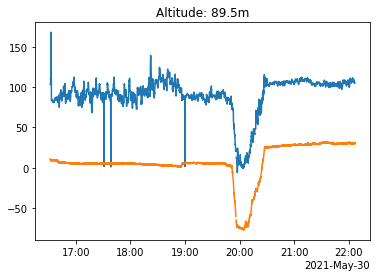

In [16]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.plot(data.index, data[['gps_altitude_m', 'pressure_altitude_m']])
ax.set_title('Altitude: {}m'.format(altitude))

In [9]:
data[data["millis"] < 334901]

,millis,voltage,satellites,hdop,gps_altitude_m,course,speed_mps,latitude,longitude,temperature_C,pressure_Pa,pressure_altitude_m,humidity_RH
2021-05-30 16:32:04,330888,7.13,5,11.67,103.2,*,*,47.687923,-122.389694,20.43,101194.64,10.86,46.36
2021-05-30 16:32:05,331891,7.24,0,99.99,103.2,*,*,47.687923,-122.389694,20.41,101195.17,10.82,46.25
2021-05-30 16:32:06,332895,7.24,4,11.69,103.2,164,6.4,47.687729,-122.389587,20.35,101193.30,10.97,46.68
2021-05-30 16:32:07,333897,7.27,4,11.69,103.2,169.7,5.1,47.687717,-122.389618,20.31,101193.97,10.92,46.98


In [63]:
data['longitude'].min() +1

-121.4134827

/Volumes/workplace/personal/graupel-1/processing/.venv/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Volumes/workplace/personal/graupel-1/processing/.venv/lib/python3.7/site-packages/pyproj/crs/crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


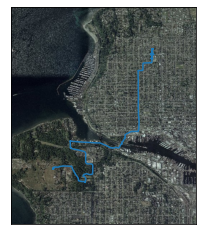

In [78]:
from mpl_toolkits.basemap import Basemap

avg_lat = data['latitude'].mean()
avg_lon = data['longitude'].mean()

fig,ax = plt.subplots()

#map = Basemap(projection='lcc', resolution='i',
#      width=2e5, height=2e5,
#      lat_0=avg_lat, lon_0=avg_lon,)
#map.shadedrelief()

padding = 0.01

# projection='cass', resolution='i', 
map = Basemap(epsg=4326,
    lat_0 = data['latitude'].mean(),
    llcrnrlat=data['latitude'].min() - padding,
    urcrnrlat=data['latitude'].max() + padding,
    llcrnrlon=data['longitude'].min() - padding,
    urcrnrlon=data['longitude'].max() + padding,
    lon_0 = data['longitude'].mean())

#map = Basemap(llcrnrlon=-10.5,llcrnrlat=33,urcrnrlon=10.,urcrnrlat=46.,
#             resolution='i', projection='cass', lat_0 = 39.5, lon_0 = 0.)

map.arcgisimage(service='ESRI_Imagery_World_2D')

#map.drawcoastlines()

ax.plot(data['longitude'], data['latitude'])
